#### Apo Challenge

## Baseline Models

In this notebook, baseline models are run for logistic regression, decision tree, and random forest. 
Beforehand, data are transformed. 

In [25]:
reset -fs

In [26]:
#! pip install -U imbalanced-learn

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report
#For upsampling data
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
import seaborn as sns
import nbimporter

In [37]:
import Stored_Functions

In [38]:
from Stored_Functions import preprocessing

In [39]:
#Load training data
X_train = pd.read_json('train_preprocessed.json').drop('zielvariable', axis = 1)
y_train =  pd.read_json('train_preprocessed.json').zielvariable

In [40]:
#Load validation data
X_val = pd.read_json('validation_preprocessed.json').drop('zielvariable', axis = 1)
y_val =  pd.read_json('validation_preprocessed.json').zielvariable

In [42]:
#Preprocssing: Rescale numeric data, encode categorical data and make a list with feature names (needed for feature importancce)
def preprocessing(X_train, X_val, y_train, y_val, train_only = False):
    '''Function to rescale numeric data and encode categorical data of train dataframe and optionally, validation data.
    Training data is additionally upsampled using SMOTENC
    Input:
    X_train: training features as pd.DataFrame
    y_train: training target as pd.DataFrame
    X_val: validation features as pd.DataFrame
    y_val: validation target as pd.DataFrame
    train_only: Bool, if False, training and validation are to be transformed, if True, only training data is transformed'''
    
    #List of categorical features
    cat = list(X_train.select_dtypes('object'))
    
    #Indices of categorical data
    cat_indices = []
    for col in cat:
        cat_indices.append(X_train.columns.get_loc(col))

    #numerical features
    num = list(X_train.select_dtypes('number')) 
    
    #Pipeline for feature transformation: rescale numerical features, numerically encode categorical features
    preprocessor = ColumnTransformer([
        ('scale_numceric', RobustScaler(), num),
        ('encode_cat', OneHotEncoder(drop = 'first'), cat)], 
        remainder = 'passthrough')
    
    #fit to train data
    preprocessor.fit(X_train)
    
    #transform train data
    X_train = pd.DataFrame(preprocessor.transform(X_train))
    y_train = pd.get_dummies(y_train, drop_first = True)
    
    #get features names 
    feature_names = num + list(preprocessor.named_transformers_['encode_cat'].get_feature_names())
    
    #Oversampling train data via smotenc 
    X_sm, y_sm = SMOTENC(categorical_features = cat_indices, random_state = 42, sampling_strategy = 'minority', n_jobs = -1).fit_sample(X_train, y_train)
    
    if train_only == True:
        return np.array(X_sm), np.array(y_sm), feature_names
    else:
        #transform validation data
        X_val = pd.DataFrame(preprocessor.transform(X_val))
        y_val = pd.get_dummies(y_val, drop_first = True)
        return np.array(X_sm), np.array(X_val), np.array(y_sm), np.array(y_val), feature_names

In [43]:
X_train, X_val, y_train, y_val, feature_names = preprocessing(X_train, X_val, y_train, y_val, train_only = False)

LogisticRegression: 0.933952 (0.002775)
DecisionTree: 0.875507 (0.003744)
RandomForest: 0.982986 (0.000540)


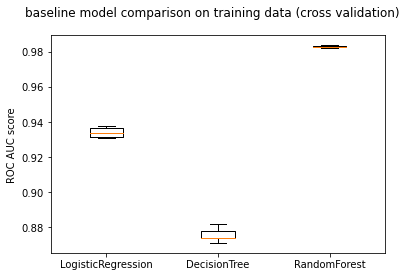

In [44]:
#First run all basic models
models = [
    ('LogisticRegression', LogisticRegression(n_jobs = 1, random_state = 42, max_iter = 1000)),
    ('DecisionTree', DecisionTreeClassifier(random_state = 42)),
    ('RandomForest', RandomForestClassifier(n_jobs = 1, random_state = 42))
]

results = []
names = []
scoring = 'roc_auc'

#Print cross validation results
#print('Average ROC AUC scores (std in brackets) for baseline models: \n')
for name, model in models:
    kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train.ravel(), cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot for baseline algorithm comparison
fig = plt.figure()
fig.suptitle('baseline model comparison on training data (cross validation)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('ROC AUC score')
plt.show()

Note that when choosing the baseline models for every algorithm, the logistic regression won't converge, so max_iter is set to 1000.

In [45]:
for name, model in models:
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_val)
    print(name)
    print(classification_report(y_val, y_pred))

LogisticRegression
              precision    recall  f1-score   support

           0       0.40      0.68      0.50       740
           1       0.95      0.87      0.91      5556

    accuracy                           0.84      6296
   macro avg       0.68      0.77      0.71      6296
weighted avg       0.89      0.84      0.86      6296

DecisionTree
              precision    recall  f1-score   support

           0       0.39      0.58      0.46       740
           1       0.94      0.88      0.91      5556

    accuracy                           0.84      6296
   macro avg       0.66      0.73      0.69      6296
weighted avg       0.87      0.84      0.86      6296

RandomForest
              precision    recall  f1-score   support

           0       0.51      0.62      0.56       740
           1       0.95      0.92      0.93      5556

    accuracy                           0.88      6296
   macro avg       0.73      0.77      0.75      6296
weighted avg       0.90      

In [46]:
# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score),
           'ROC_AUC_score': make_scorer(roc_auc_score)
          }

# Import required libraries for machine learning classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the machine learning classifiers
log_model = LogisticRegression(max_iter=1000, random_state = 42)
dtc_model = DecisionTreeClassifier(random_state = 42)
rfc_model = RandomForestClassifier(random_state = 42)

# Define the models evaluation function
def models_evaluation(X, y, kfolds):
    ''' X : data set features
    y : data set target
    folds : number of cross-validation folds'''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y, cv = kfolds, scoring = scoring)
    dtc = cross_validate(dtc_model, X, y, cv = kfolds, scoring = scoring)
    rfc = cross_validate(rfc_model, X, y, cv = kfolds, scoring = scoring)

    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean(),
                                                               log['test_ROC_AUC_score'].mean()],
                                       
                                      'Decision Tree':[dtc['test_accuracy'].mean(),
                                                       dtc['test_precision'].mean(),
                                                       dtc['test_recall'].mean(),
                                                       dtc['test_f1_score'].mean(),
                                                       dtc['test_ROC_AUC_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean(),
                                                       rfc['test_ROC_AUC_score'].mean()]}, index = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)
  
# Run models_evaluation function
models_evaluation(X_train, y_train.ravel(), 5)

/home/julia/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: Shape of passed values is (5, 3), indices imply (4, 3)